# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [ ]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

sources = [
    mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),     # 연속파 광원
              component=mp.Ez,                # z 방향 전기장
              center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))
]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
                    

0.5333333333333333


<Axes: xlabel='X', ylabel='Y'>

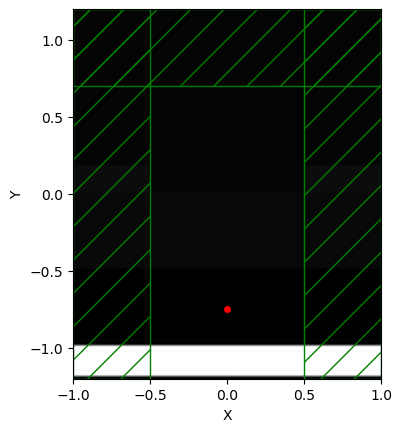

In [3]:
sim.plot2D()

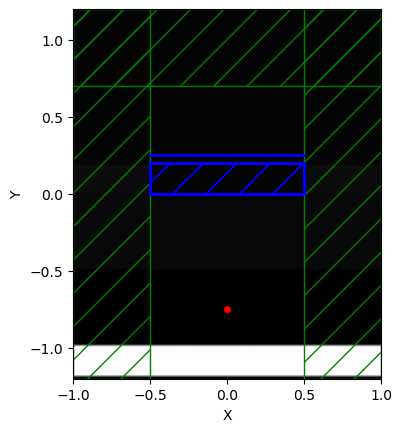

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.sum(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)
opt.plot2D(True)

In [5]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [6]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [7]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [8]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 4.596149053327791
Gradient: [ 7.59817158e-03  1.94975084e-02  2.45973232e-02  2.49411638e-02
  1.93879256e-02  7.61926660e-03 -7.91943362e-03 -1.84298358e-02
 -2.34381967e-02 -2.21594192e-02 -2.21854731e-02  6.33280063e-03
  1.66893543e-02  2.22550695e-02  2.42855940e-02  2.13607207e-02
  1.35379066e-02  2.49940645e-04 -8.79747001e-03 -1.34711511e-02
 -1.28532087e-02 -1.02751271e-02  6.03853463e-03  1.65386064e-02
  2.35618886e-02  2.72843786e-02  2.57189944e-02  1.89674017e-02
  4.66516929e-03 -5.20053342e-03 -1.04526678e-02 -9.84293480e-03
 -4.49170111e-03  4.47092494e-03  1.32078778e-02  2.09923852e-02
  2.62263215e-02  2.64362180e-02  2.15317430e-02  7.78396540e-03
 -1.92875761e-03 -7.14898549e-03 -6.32540856e-03  1.92601224e-03
  2.00922460e-03  7.51640122e-03  1.52406282e-02  2.15695413e-02
  2.36786608e-02  2.10641876e-02  9.20166905e-03  4.49322889e-04
 -4.24876029e-03 -3.07173051e-03  7.70946602e-03 -7.72308448e-04
  7.92430074e-04  7.68079149e-03 

Calculating gradient...
FoM: 4.612665071437803
Gradient: [ 7.67521091e-03  1.96864874e-02  2.48191838e-02  2.51636960e-02
  1.95710107e-02  7.73682768e-03 -7.88741926e-03 -1.84400830e-02
 -2.34714013e-02 -2.22027713e-02 -2.22564768e-02  6.39161500e-03
  1.68417473e-02  2.24544920e-02  2.45073322e-02  2.15675581e-02
  1.37059059e-02  3.36969758e-04 -8.75296016e-03 -1.34541182e-02
 -1.28530529e-02 -1.02927329e-02  6.08793597e-03  1.66738291e-02
  2.37561897e-02  2.75168795e-02  2.59508012e-02  1.91708234e-02
  4.78160570e-03 -5.13160771e-03 -1.04151558e-02 -9.82439574e-03
 -4.48163952e-03  4.49800502e-03  1.32913396e-02  2.11335700e-02
  2.64135138e-02  2.66369974e-02  2.17186736e-02  7.89625997e-03
 -1.85797477e-03 -7.10393185e-03 -6.29270718e-03  1.97155744e-03
  2.00816552e-03  7.53003037e-03  1.52978649e-02  2.16703224e-02
  2.38034614e-02  2.11905978e-02  9.28139273e-03  5.03838862e-04
 -4.20531188e-03 -3.02632924e-03  7.79998981e-03 -7.98142154e-04
  7.41113868e-04  7.65132513e-03 

Calculating gradient...
FoM: 4.762069419850473
Gradient: [ 0.0083409   0.0213266   0.02676142  0.02712498  0.02119557  0.00878775
 -0.00759659 -0.01852658 -0.02376416 -0.02258537 -0.0228774   0.00690408
  0.0181761   0.02421558  0.02647763  0.02341673  0.01521749  0.0011229
 -0.00835034 -0.01330047 -0.01285204 -0.01044956  0.00651809  0.01785844
  0.02547418  0.02958506  0.02802462  0.02100198  0.00583194 -0.00451225
 -0.01008275 -0.00966617 -0.00440617  0.00473026  0.01401603  0.02237717
  0.02807495  0.02843006  0.02339917  0.00890764 -0.00122575 -0.00671035
 -0.00601676  0.00234698  0.00199098  0.00763415  0.01579206  0.02255806
  0.02491381  0.02232517  0.00999882  0.0009878  -0.00383038 -0.00264299
  0.00856523 -0.00103325  0.00027189  0.0073756   0.01458019  0.01872792
  0.01866055  0.00942386  0.00208109 -0.00178755 -0.00012009  0.01305898
 -0.00368131 -0.0064699  -0.00103014  0.00600881  0.01153831  0.01376989
  0.00788967  0.00232645 -0.00067258  0.00117538  0.01485604 -0.0054

Calculating gradient...
FoM: 5.966509667707353
Gradient: [ 0.01230355  0.03140931  0.03945298  0.04054791  0.03275824  0.01652085
 -0.00539706 -0.01912334 -0.02590659 -0.02535502 -0.02717282  0.01016419
  0.0269841   0.03658673  0.04097051  0.03758822  0.02729329  0.00759101
 -0.00494309 -0.01192205 -0.01272238 -0.01149344  0.00923769  0.02570929
  0.03767937  0.0449939   0.04411991  0.03582174  0.01456926  0.00065582
 -0.00737297 -0.00851087 -0.00417651  0.00601407  0.01846882  0.03093169
  0.04023522  0.042185    0.03690444  0.017289    0.00394211 -0.00372878
 -0.00428127  0.00416513  0.00147137  0.00749865  0.01856754  0.02855532
  0.03306041  0.03121284  0.01585983  0.00481681 -0.00122149 -0.000386
  0.01275345 -0.00303097 -0.00388642  0.00444329  0.01385964  0.0202211
  0.02162979  0.01188212  0.00411413  0.00036962  0.00286533  0.02027393
 -0.00633284 -0.01273227 -0.00768583  0.00027676  0.00760714  0.0116497
  0.00740175  0.00290399  0.00127473  0.00498092  0.02488923 -0.0078808

Calculating gradient...
FoM: 8.074643133802471
Gradient: [ 1.60304165e-02  4.23109172e-02  5.66882080e-02  6.24488960e-02
  5.55491354e-02  3.63176458e-02  3.59721193e-03 -1.73298890e-02
 -2.93497358e-02 -3.17801627e-02 -3.84527736e-02  1.39991933e-02
  3.86402705e-02  5.61139157e-02  6.72713752e-02  6.72257680e-02
  5.74071191e-02  2.68417661e-02  6.39477869e-03 -6.76709505e-03
 -1.18098991e-02 -1.43204049e-02  1.23864137e-02  3.62246642e-02
  5.73409927e-02  7.33215473e-02  7.78018494e-02  7.22044876e-02
  3.97963639e-02  1.66548481e-02  1.01826145e-03 -5.53097473e-03
 -5.40559699e-03  6.84465216e-03  2.32491362e-02  4.37805876e-02
  6.17413518e-02  7.00722832e-02  6.90403489e-02  4.07163133e-02
  1.91835145e-02  4.26973498e-03 -1.43367214e-03  3.32050674e-03
 -5.50648666e-04  4.58220615e-03  2.06258128e-02  3.73577722e-02
  4.79777398e-02  5.08994683e-02  3.11838242e-02  1.48910693e-02
  3.88687681e-03  1.39843935e-03  1.30313793e-02 -6.95816570e-03
 -1.26264131e-02 -3.27123091e-03 

Calculating gradient...
FoM: 8.132362661111653
Gradient: [ 1.80595803e-02  4.40279943e-02  5.01400922e-02  4.56944412e-02
  2.90510493e-02 -5.93917991e-04 -3.00267885e-02 -4.64194826e-02
 -5.19752338e-02 -4.75118406e-02 -5.19963025e-02  1.58706019e-02
  4.15625747e-02  5.50813995e-02  6.07327223e-02  5.52245520e-02
  4.01637022e-02  1.18108868e-02 -5.66106027e-03 -1.48437613e-02
 -1.59176199e-02 -1.55218227e-02  1.43793891e-02  4.01381320e-02
  5.92073029e-02  7.15251123e-02  7.20631690e-02  6.31424488e-02
  3.25121444e-02  1.22698139e-02 -2.28538217e-04 -4.04676826e-03
 -9.77318471e-04  8.28213173e-03  2.65745386e-02  4.68638482e-02
  6.30454025e-02  6.90227280e-02  6.63845990e-02  3.95067594e-02
  2.07036083e-02  8.28864475e-03  4.15398028e-03  1.10468527e-02
 -4.78981996e-04  5.29294749e-03  2.23848983e-02  3.88068453e-02
  4.83645914e-02  5.07823603e-02  3.24738453e-02  1.88391328e-02
  1.02532907e-02  8.88103876e-03  2.18345833e-02 -8.98324471e-03
 -1.63235730e-02 -5.02449235e-03 

Calculating gradient...
FoM: 8.071017427897402
Gradient: [ 2.46012305e-02  6.54277192e-02  8.96914950e-02  1.03878203e-01
  1.02183377e-01  8.77677776e-02  4.40781842e-02  1.55044186e-02
 -4.88222853e-03 -1.54390790e-02 -2.62038767e-02  1.84094339e-02
  5.08668258e-02  7.43576238e-02  9.09114676e-02  9.45534530e-02
  8.85355250e-02  5.21739338e-02  2.68991665e-02  8.11945907e-03
 -2.29126674e-03 -8.11169850e-03  1.46255629e-02  4.27181423e-02
  6.77157719e-02  8.74616643e-02  9.48902156e-02  9.27358241e-02
  5.73594782e-02  3.12426551e-02  1.13666687e-02  6.92786180e-04
 -2.30548692e-03  7.11997192e-03  2.42389403e-02  4.58361886e-02
  6.51105870e-02  7.48470215e-02  7.58295564e-02  4.74809257e-02
  2.54792526e-02  8.93548869e-03  1.45088568e-03  4.74232274e-03
 -9.15468137e-04  3.25241783e-03  1.79790661e-02  3.36099686e-02
  4.37954255e-02  4.69401190e-02  2.91208938e-02  1.44036917e-02
  4.57583476e-03  3.05470358e-03  1.65793470e-02 -6.34999176e-03
 -1.21138200e-02 -5.13691225e-03 

Calculating gradient...
FoM: 8.402375675601531
Gradient: [ 2.39216537e-02  6.21706845e-02  8.15616656e-02  9.01428440e-02
  8.32747573e-02  6.31882500e-02  2.15542506e-02 -5.14203380e-03
 -2.19498755e-02 -2.79947605e-02 -3.73446849e-02  1.88488310e-02
  5.12218112e-02  7.27725440e-02  8.66109557e-02  8.73664508e-02
  7.80722747e-02  4.20295199e-02  1.76679383e-02  8.19898103e-04
 -7.08188361e-03 -1.10938301e-02  1.56276706e-02  4.49256000e-02
  6.95182444e-02  8.79333396e-02  9.34071598e-02  8.87938148e-02
  5.27345936e-02  2.69799963e-02  8.33196620e-03 -6.61189953e-04
 -1.70475977e-03  8.00742660e-03  2.66981107e-02  4.92812046e-02
  6.86716593e-02  7.76271178e-02  7.73328350e-02  4.77160265e-02
  2.55491751e-02  9.51700305e-03  2.80344440e-03  7.60936376e-03
 -1.02437392e-03  3.75520069e-03  2.03210999e-02  3.71981073e-02
  4.77313456e-02  5.07318691e-02  3.17928546e-02  1.67987045e-02
  7.09346529e-03  5.72693475e-03  2.00618155e-02 -8.14278710e-03
 -1.53467180e-02 -6.27377320e-03 

Calculating gradient...
FoM: 8.550829062622107
Gradient: [ 2.15995230e-02  5.47561782e-02  6.81560220e-02  7.04143941e-02
  5.80918147e-02  3.15409388e-02 -6.44407802e-03 -3.03315396e-02
 -4.30828831e-02 -4.44039088e-02 -5.39405969e-02  1.79436554e-02
  4.82070051e-02  6.70468428e-02  7.79250790e-02  7.61272186e-02
  6.40037270e-02  2.98054062e-02  6.94680898e-03 -7.77054742e-03
 -1.32732973e-02 -1.64311703e-02  1.53101793e-02  4.38355886e-02
  6.73431682e-02  8.44459866e-02  8.87666655e-02  8.30294826e-02
  4.79409466e-02  2.31167774e-02  5.55999299e-03 -2.34024412e-03
 -2.66203109e-03  7.79795863e-03  2.63800156e-02  4.93323656e-02
  6.89710795e-02  7.81530770e-02  7.83446790e-02  4.91173609e-02
  2.72764238e-02  1.12590329e-02  4.20377796e-03  8.50394679e-03
 -1.86723851e-03  2.29311597e-03  2.00343293e-02  3.81315665e-02
  4.98420409e-02  5.43181715e-02  3.57209222e-02  2.07430930e-02
  1.03609620e-02  7.64252632e-03  1.95590079e-02 -1.02486222e-02
 -1.96203018e-02 -9.24732983e-03 

Calculating gradient...
FoM: 8.625501936455787
Gradient: [ 2.41130115e-02  6.27355202e-02  8.24254257e-02  9.10555764e-02
  8.37290963e-02  6.21722917e-02  1.84874296e-02 -1.02756817e-02
 -2.86789532e-02 -3.53502848e-02 -4.77646230e-02  1.90336797e-02
  5.20382009e-02  7.46928954e-02  8.97019188e-02  9.13382685e-02
  8.26220028e-02  4.51185163e-02  1.91297491e-02  4.64631613e-04
 -8.67480362e-03 -1.42668023e-02  1.55042526e-02  4.51635370e-02
  7.12519849e-02  9.15102282e-02  9.87218757e-02  9.58742389e-02
  5.87772944e-02  3.15311658e-02  1.07355169e-02 -1.13595253e-04
 -2.84350040e-03  7.28985550e-03  2.55044886e-02  4.94074366e-02
  7.07358884e-02  8.18105235e-02  8.39035627e-02  5.39931721e-02
  3.07542027e-02  1.27851639e-02  4.02619641e-03  6.67228704e-03
 -2.36380268e-03  9.01771881e-04  1.81261917e-02  3.64256299e-02
  4.88757460e-02  5.41726155e-02  3.58429838e-02  2.04067479e-02
  9.31998946e-03  6.18564908e-03  1.78622006e-02 -9.85728568e-03
 -1.93375079e-02 -1.04090379e-02 

Calculating gradient...
FoM: 8.699378617175078
Gradient: [ 0.0222864   0.05664214  0.07090635  0.07382632  0.06166161  0.03465251
 -0.00531067 -0.03098043 -0.04527049 -0.04758936 -0.05940321  0.01836651
  0.04957217  0.06953956  0.08157722  0.08065254  0.06924981  0.0337767
  0.00959215 -0.00657963 -0.01324359 -0.01760988  0.0154234   0.04452534
  0.069275    0.08784732  0.09350608  0.08917362  0.05323252  0.02731411
  0.00821414 -0.00114564 -0.00273076  0.00743687  0.0258717   0.04976559
  0.07074911  0.08135782  0.08316952  0.05372246  0.03122163  0.01396615
  0.00550281  0.00832587 -0.00264837  0.00060986  0.01869832  0.03763182
  0.05046977  0.05628636  0.03812215  0.02298593  0.01188108  0.00814496
  0.01849172 -0.01121687 -0.02194934 -0.011843    0.00205584  0.01443164
  0.02204138  0.01630373  0.01014177  0.00726972  0.01033584  0.03109181
 -0.01611516 -0.03577975 -0.03272949 -0.02408994 -0.01353728 -0.00549982
 -0.00121662  0.00055019  0.00524404  0.01466403  0.04648546 -0.0169

Calculating gradient...
FoM: 8.737958729900198
Gradient: [ 2.41243100e-02  6.21831824e-02  8.02226616e-02  8.68777809e-02
  7.76084654e-02  5.36771935e-02  1.04683169e-02 -1.79109364e-02
 -3.53782011e-02 -4.08195546e-02 -5.38105104e-02  1.93002490e-02
  5.24995068e-02  7.47112522e-02  8.90449873e-02  8.99269991e-02
  8.03504552e-02  4.28978276e-02  1.70127170e-02 -1.27568195e-03
 -9.95751851e-03 -1.54758472e-02  1.58624421e-02  4.60507410e-02
  7.22957245e-02  9.25072752e-02  9.95139303e-02  9.64803604e-02
  5.92205811e-02  3.19935772e-02  1.12661784e-02  4.00661565e-04
 -2.32994272e-03  7.47840895e-03  2.61507841e-02  5.06107175e-02
  7.23640732e-02  8.36771708e-02  8.60888082e-02  5.60139670e-02
  3.27668353e-02  1.46435396e-02  5.46973057e-03  7.65052613e-03
 -2.61827132e-03  5.76888826e-04  1.84570104e-02  3.73767580e-02
  5.02993002e-02  5.61091312e-02  3.78069000e-02  2.24339181e-02
  1.11592497e-02  7.47577817e-03  1.81380622e-02 -1.07223658e-02
 -2.10914437e-02 -1.16281812e-02 

Calculating gradient...
FoM: 8.737958729900198
Gradient: [ 2.41243100e-02  6.21831824e-02  8.02226616e-02  8.68777809e-02
  7.76084654e-02  5.36771935e-02  1.04683169e-02 -1.79109364e-02
 -3.53782011e-02 -4.08195546e-02 -5.38105104e-02  1.93002490e-02
  5.24995068e-02  7.47112522e-02  8.90449873e-02  8.99269991e-02
  8.03504552e-02  4.28978276e-02  1.70127170e-02 -1.27568195e-03
 -9.95751851e-03 -1.54758472e-02  1.58624421e-02  4.60507410e-02
  7.22957245e-02  9.25072752e-02  9.95139303e-02  9.64803604e-02
  5.92205811e-02  3.19935772e-02  1.12661784e-02  4.00661565e-04
 -2.32994272e-03  7.47840895e-03  2.61507841e-02  5.06107175e-02
  7.23640732e-02  8.36771708e-02  8.60888082e-02  5.60139670e-02
  3.27668353e-02  1.46435396e-02  5.46973057e-03  7.65052613e-03
 -2.61827132e-03  5.76888826e-04  1.84570104e-02  3.73767580e-02
  5.02993002e-02  5.61091312e-02  3.78069000e-02  2.24339181e-02
  1.11592497e-02  7.47577817e-03  1.81380622e-02 -1.07223658e-02
 -2.10914437e-02 -1.16281812e-02 

Calculating gradient...
FoM: 8.738316403326577
Gradient: [ 2.41159298e-02  6.21554985e-02  8.01707648e-02  8.68001787e-02
  7.75087850e-02  5.35519612e-02  1.03583969e-02 -1.80089527e-02
 -3.54585146e-02 -4.08802384e-02 -5.38701336e-02  1.92965479e-02
  5.24868637e-02  7.46866414e-02  8.90073096e-02  8.98782111e-02
  8.02898754e-02  4.28463321e-02  1.69681044e-02 -1.30966742e-03
 -9.98047064e-03 -1.54938935e-02  1.58607359e-02  4.60447577e-02
  7.22836080e-02  9.24879242e-02  9.94883525e-02  9.64489462e-02
  5.91950226e-02  3.19737306e-02  1.12537505e-02  3.94882710e-04
 -2.33073593e-03  7.47721536e-03  2.61480108e-02  5.06074212e-02
  7.23594084e-02  8.36712826e-02  8.60828400e-02  5.60116503e-02
  3.27684356e-02  1.46485961e-02  5.47613967e-03  7.65770516e-03
 -2.62153433e-03  5.70730945e-04  1.84539064e-02  3.73763640e-02
  5.03013756e-02  5.61147499e-02  3.78154219e-02  2.24448842e-02
  1.11706200e-02  7.48442743e-03  1.81402961e-02 -1.07301008e-02
 -2.11072804e-02 -1.16397593e-02 

Calculating gradient...
FoM: 8.741450428167873
Gradient: [ 2.40415159e-02  6.19095712e-02  7.97095542e-02  8.61104024e-02
  7.66226391e-02  5.24382857e-02  9.37992129e-03 -1.88809309e-02
 -3.61725809e-02 -4.14194446e-02 -5.43994861e-02  1.92634952e-02
  5.23741094e-02  7.44674661e-02  8.86720362e-02  8.94443419e-02
  7.97514714e-02  4.23888943e-02  1.65720958e-02 -1.61097520e-03
 -1.01836046e-02 -1.56530546e-02  1.58451886e-02  4.59906425e-02
  7.21748199e-02  9.23148226e-02  9.92600958e-02  9.61692426e-02
  5.89680426e-02  3.17980309e-02  1.11443693e-02  3.44684892e-04
 -2.33632285e-03  7.46601255e-03  2.61218856e-02  5.05763175e-02
  7.23159595e-02  8.36170133e-02  8.60281361e-02  5.59903769e-02
  3.27827801e-02  1.46942963e-02  5.53408519e-03  7.72266965e-03
 -2.65126297e-03  5.14183548e-04  1.84240433e-02  3.73702266e-02
  5.03170356e-02  5.61618511e-02  3.78893952e-02  2.25415074e-02
  1.12716317e-02  7.56166850e-03  1.81606125e-02 -1.07996185e-02
 -2.12499372e-02 -1.17450120e-02 

Calculating gradient...
FoM: 8.757179519471256
Gradient: [ 2.35026233e-02  6.01611566e-02  7.64973649e-02  8.13639147e-02
  7.05767017e-02  4.48883655e-02  2.75405684e-03 -2.47139795e-02
 -4.08973753e-02 -4.49502945e-02 -5.78237571e-02  1.90060419e-02
  5.15252272e-02  7.28766647e-02  8.62901776e-02  8.64094731e-02
  7.60372861e-02  3.92691830e-02  1.39101647e-02 -3.60462401e-03
 -1.15034013e-02 -1.66580243e-02  1.57040493e-02  4.55293099e-02
  7.13094872e-02  9.09957318e-02  9.75718664e-02  9.41538906e-02
  5.73721174e-02  3.05938876e-02  1.04204424e-02  3.55622053e-05
 -2.33195423e-03  7.35869550e-03  2.58582922e-02  5.02393646e-02
  7.18670468e-02  8.30872054e-02  8.55025139e-02  5.57540304e-02
  3.28336335e-02  1.49914849e-02  5.93245755e-03  8.17522868e-03
 -2.87545253e-03  6.58065324e-05  1.81200915e-02  3.71958833e-02
  5.02744282e-02  5.63255551e-02  3.82876205e-02  2.31339480e-02
  1.19247165e-02  8.07013515e-03  1.82814840e-02 -1.12849367e-02
 -2.22579541e-02 -1.25245363e-02 

Calculating gradient...
FoM: 8.767977417849679
Gradient: [ 2.27006614e-02  5.75249614e-02  7.15820640e-02  7.40351301e-02
  6.11752749e-02  3.30208954e-02 -7.91268940e-03 -3.39744019e-02
 -4.83103977e-02 -5.04370711e-02 -6.31150083e-02  1.85296272e-02
  5.00100809e-02  7.01481911e-02  8.22893870e-02  8.13833758e-02
  6.99525617e-02  3.41832356e-02  9.62968843e-03 -6.75372435e-03
 -1.35464567e-02 -1.81831283e-02  1.53308410e-02  4.44192559e-02
  6.94572379e-02  8.83659865e-02  9.43648490e-02  9.04733941e-02
  5.45515029e-02  2.85341272e-02  9.23731308e-03 -4.22625159e-04
 -2.25819903e-03  7.00050479e-03  2.49557979e-02  4.90704560e-02
  7.04244897e-02  8.15074094e-02  8.39699780e-02  5.49501188e-02
  3.26863177e-02  1.53937961e-02  6.58731336e-03  8.96262168e-03
 -3.39772583e-03 -1.08565248e-03  1.70348050e-02  3.61991245e-02
  4.94577902e-02  5.58589826e-02  3.84660538e-02  2.38419318e-02
  1.28981427e-02  8.89963092e-03  1.85174057e-02 -1.21518515e-02
 -2.41300054e-02 -1.41737014e-02 

Calculating gradient...
FoM: 8.765305822135305
Gradient: [ 2.46829730e-02  6.35727425e-02  8.19441450e-02  8.88469487e-02
  7.96890795e-02  5.58439937e-02  1.19567761e-02 -1.69974039e-02
 -3.49802182e-02 -4.08643712e-02 -5.45000834e-02  1.95549311e-02
  5.31868913e-02  7.57081441e-02  9.03597730e-02  9.15223168e-02
  8.23223124e-02  4.46285302e-02  1.84230825e-02 -2.45587885e-04
 -9.32360870e-03 -1.51705473e-02  1.59058097e-02  4.62322184e-02
  7.27243515e-02  9.32578177e-02  1.00618034e-01  9.80860091e-02
  6.08401007e-02  3.35277459e-02  1.25330417e-02  1.26845001e-03
 -1.82333678e-03  7.29381465e-03  2.57523704e-02  5.02957035e-02
  7.22610867e-02  8.38829206e-02  8.67579119e-02  5.69747421e-02
  3.38910563e-02  1.56986767e-02  6.21795809e-03  7.94334196e-03
 -2.94786774e-03 -2.13925979e-04  1.75727931e-02  3.65330818e-02
  4.96387412e-02  5.57547461e-02  3.79313198e-02  2.29113342e-02
  1.17567676e-02  7.90537462e-03  1.80491764e-02 -1.10841282e-02
 -2.19852152e-02 -1.27085766e-02 

Calculating gradient...
FoM: 8.774500632465285
Gradient: [ 0.02370767  0.0606222   0.07694392  0.08174964  0.07086482  0.04503143
  0.00262916 -0.02501174 -0.04128352 -0.0453816  -0.05852782  0.01907185
  0.05169204  0.07309608  0.08657187  0.08676583  0.07652509  0.03974547
  0.01428818 -0.00331385 -0.0113094  -0.01656158  0.01565638  0.04543493
  0.07126251  0.09104205  0.09775874  0.09457533  0.05791738  0.03118484
  0.01097661  0.00047216 -0.0020038   0.00718493  0.02545678  0.04983025
  0.07152275  0.08288403  0.08554154  0.05606288  0.03332929  0.01554471
  0.00638682  0.00844725 -0.00314201 -0.00056944  0.01741089  0.03648837
  0.04966288  0.05588995  0.03821652  0.02334883  0.01228145  0.0083719
  0.01831177 -0.01159202 -0.02299478 -0.01336724  0.00026475  0.01263655
  0.02032341  0.01524788  0.00962861  0.00716894  0.01045603  0.03135797
 -0.01607414 -0.03593462 -0.03349981 -0.02530627 -0.01492996 -0.00687442
 -0.00209628  0.00020123  0.00543867  0.01527475  0.04783924 -0.0163

Calculating gradient...
FoM: 8.775958387997335
Gradient: [ 2.34542538e-02  5.97977446e-02  7.54214504e-02  7.94839693e-02
  6.79580660e-02  4.13673936e-02 -6.32247706e-04 -2.78420982e-02
 -4.35485824e-02 -4.70532851e-02 -6.01191014e-02  1.89328622e-02
  5.12424407e-02  7.22690829e-02  8.53396788e-02  8.51945038e-02
  7.45896360e-02  3.81010148e-02  1.28940944e-02 -4.35353688e-03
 -1.19954780e-02 -1.70807929e-02  1.55643715e-02  4.51460087e-02
  7.07448784e-02  9.02713849e-02  9.67807628e-02  9.33999027e-02
  5.69657507e-02  3.04487050e-02  1.05102475e-02  2.46828589e-04
 -2.05058294e-03  7.11348736e-03  2.52713271e-02  4.95725854e-02
  7.11770566e-02  8.24725006e-02  8.50979714e-02  5.57800106e-02
  3.32084965e-02  1.55794153e-02  6.51417412e-03  8.64557045e-03
 -3.25208993e-03 -8.01530645e-04  1.72186530e-02  3.63318730e-02
  4.95501099e-02  5.58559267e-02  3.83040957e-02  2.35458573e-02
  1.25341209e-02  8.58802129e-03  1.83912079e-02 -1.18040989e-02
 -2.34383759e-02 -1.37195400e-02 

Calculating gradient...
FoM: 8.774616634641829
Gradient: [ 2.44126080e-02  6.26825012e-02  8.02832861e-02  8.63764514e-02
  7.65312439e-02  5.19025637e-02  8.52521947e-03 -1.99818178e-02
 -3.73491382e-02 -4.25780617e-02 -5.60531237e-02  1.94280546e-02
  5.27545104e-02  7.48689153e-02  8.90775149e-02  8.98606709e-02
  8.02573191e-02  4.28815916e-02  1.69463893e-02 -1.32731379e-03
 -1.00098471e-02 -1.56205618e-02  1.58480158e-02  4.60207792e-02
  7.22798374e-02  9.25356520e-02  9.96421835e-02  9.68513574e-02
  5.98104424e-02  3.27302135e-02  1.20492244e-02  1.06801203e-03
 -1.77069695e-03  7.26508209e-03  2.56735485e-02  5.01659692e-02
  7.20384881e-02  8.35492342e-02  8.63158241e-02  5.66395734e-02
  3.37220498e-02  1.57281672e-02  6.39051011e-03  8.27455441e-03
 -3.03244414e-03 -3.71302554e-04  1.74960242e-02  3.65094316e-02
  4.96265657e-02  5.57452778e-02  3.79753681e-02  2.30638184e-02
  1.20097049e-02  8.18587688e-03  1.83168490e-02 -1.13191112e-02
 -2.24592634e-02 -1.30386515e-02 

Calculating gradient...
FoM: 8.77751970399826
Gradient: [ 2.37876744e-02  6.07861909e-02  7.70546504e-02  8.17731934e-02
  7.07843761e-02  4.48207899e-02  2.35764635e-03 -2.53070852e-02
 -4.15730621e-02 -4.56492148e-02 -5.88851247e-02  1.91117592e-02
  5.17789157e-02  7.31702529e-02  8.66175708e-02  8.67762888e-02
  7.65011609e-02  3.97100762e-02  1.42457814e-02 -3.35211884e-03
 -1.13458701e-02 -1.66213883e-02  1.56691183e-02  4.54642445e-02
  7.12918753e-02  9.10662364e-02  9.77762530e-02  9.45963793e-02
  5.79535477e-02  3.12429980e-02  1.10496742e-02  5.37246935e-04
 -1.95630148e-03  7.16350745e-03  2.54083406e-02  4.97835255e-02
  7.14852097e-02  8.28586452e-02  8.55404526e-02  5.61047424e-02
  3.34220460e-02  1.56687175e-02  6.50045080e-03  8.52523163e-03
 -3.19364747e-03 -6.88551506e-04  1.72881982e-02  3.63758908e-02
  4.95691392e-02  5.58234296e-02  3.82100455e-02  2.34148273e-02
  1.23925953e-02  8.47503766e-03  1.83501518e-02 -1.16693143e-02
 -2.31716420e-02 -1.35490361e-02  

Calculating gradient...
FoM: 8.77904129599352
Gradient: [ 2.34582963e-02  5.95768588e-02  7.45437464e-02  7.78221012e-02
  6.55348383e-02  3.79942049e-02 -3.93103875e-03 -3.08508315e-02
 -4.60619681e-02 -4.89808741e-02 -6.20180580e-02  1.88558087e-02
  5.09388363e-02  7.16004854e-02  8.42600128e-02  8.37529941e-02
  7.27530259e-02  3.64991919e-02  1.14959091e-02 -5.40720837e-03
 -1.26908015e-02 -1.75477972e-02  1.54221323e-02  4.47310167e-02
  7.00727974e-02  8.93394220e-02  9.56508240e-02  9.20897171e-02
  5.59481764e-02  2.97134296e-02  1.01219480e-02  1.41571213e-04
 -1.86203089e-03  6.90959044e-03  2.47500635e-02  4.88970641e-02
  7.03927135e-02  8.16370511e-02  8.42540975e-02  5.52578007e-02
  3.30072897e-02  1.57007248e-02  6.83732025e-03  9.20111502e-03
 -3.51668403e-03 -1.43215259e-03  1.65109383e-02  3.56061573e-02
  4.88630130e-02  5.52483394e-02  3.80106900e-02  2.35644870e-02
  1.28253155e-02  9.00891460e-03  1.88992569e-02 -1.21731610e-02
 -2.42724773e-02 -1.45562034e-02 -

Calculating gradient...
FoM: 8.77961966242319
Gradient: [ 2.45597805e-02  6.29685736e-02  8.04096056e-02  8.62109496e-02
  7.59805756e-02  5.07586862e-02  7.03818958e-03 -2.17096557e-02
 -3.90937739e-02 -4.41554369e-02 -5.79021020e-02  1.94039864e-02
  5.26819403e-02  7.47402053e-02  8.88702614e-02  8.95656563e-02
  7.98177620e-02  4.23915830e-02  1.63222414e-02 -1.96685996e-03
 -1.05810700e-02 -1.62030624e-02  1.56854087e-02  4.56342145e-02
  7.18531928e-02  9.21208559e-02  9.92852805e-02  9.65521974e-02
  5.96054558e-02  3.25347369e-02  1.18857932e-02  9.40339223e-04
 -1.82306772e-03  6.98287327e-03  2.49998337e-02  4.94263816e-02
  7.13588294e-02  8.30237232e-02  8.59904178e-02  5.65622798e-02
  3.37776334e-02  1.58696704e-02  6.55821358e-03  8.52361692e-03
 -3.36726876e-03 -1.18134017e-03  1.65754757e-02  3.56194912e-02
  4.89015920e-02  5.52612404e-02  3.78362826e-02  2.31273336e-02
  1.21912033e-02  8.39259544e-03  1.85369996e-02 -1.16653783e-02
 -2.32912127e-02 -1.39882938e-02 -

Calculating gradient...
FoM: 8.77961966242319
Gradient: [ 2.45597805e-02  6.29685736e-02  8.04096056e-02  8.62109496e-02
  7.59805756e-02  5.07586862e-02  7.03818958e-03 -2.17096557e-02
 -3.90937739e-02 -4.41554369e-02 -5.79021020e-02  1.94039864e-02
  5.26819403e-02  7.47402053e-02  8.88702614e-02  8.95656563e-02
  7.98177620e-02  4.23915830e-02  1.63222414e-02 -1.96685996e-03
 -1.05810700e-02 -1.62030624e-02  1.56854087e-02  4.56342145e-02
  7.18531928e-02  9.21208559e-02  9.92852805e-02  9.65521974e-02
  5.96054558e-02  3.25347369e-02  1.18857932e-02  9.40339223e-04
 -1.82306772e-03  6.98287327e-03  2.49998337e-02  4.94263816e-02
  7.13588294e-02  8.30237232e-02  8.59904178e-02  5.65622798e-02
  3.37776334e-02  1.58696704e-02  6.55821358e-03  8.52361692e-03
 -3.36726876e-03 -1.18134017e-03  1.65754757e-02  3.56194912e-02
  4.89015920e-02  5.52612404e-02  3.78362826e-02  2.31273336e-02
  1.21912033e-02  8.39259544e-03  1.85369996e-02 -1.16653783e-02
 -2.32912127e-02 -1.39882938e-02 -

Calculating gradient...
FoM: 8.779697737248839
Gradient: [ 2.45541659e-02  6.29506050e-02  8.03770028e-02  8.61628028e-02
  7.59190360e-02  5.06812541e-02  6.96936743e-03 -2.17700601e-02
 -3.91425861e-02 -4.41917484e-02 -5.79368441e-02  1.94009163e-02
  5.26721935e-02  7.47226435e-02  8.88443489e-02  8.95327790e-02
  7.97773377e-02  4.23571701e-02  1.62926723e-02 -1.98924819e-03
 -1.05960545e-02 -1.62145119e-02  1.56833595e-02  4.56279357e-02
  7.18422714e-02  9.21048480e-02  9.92651587e-02  9.65281142e-02
  5.95858643e-02  3.25193026e-02  1.18757217e-02  9.35262338e-04
 -1.82429916e-03  6.98127314e-03  2.49957611e-02  4.94209420e-02
  7.13517744e-02  8.30155759e-02  8.59818792e-02  5.65569422e-02
  3.37753491e-02  1.58703312e-02  6.56070290e-03  8.52768855e-03
 -3.36968345e-03 -1.18641792e-03  1.65713271e-02  3.56162560e-02
  4.88995447e-02  5.52611614e-02  3.78386830e-02  2.31316976e-02
  1.21964174e-02  8.39690627e-03  1.85384910e-02 -1.16699766e-02
 -2.33008371e-02 -1.39959450e-02 

Calculating gradient...
FoM: 8.779697737248839
Gradient: [ 2.45541659e-02  6.29506050e-02  8.03770028e-02  8.61628028e-02
  7.59190360e-02  5.06812541e-02  6.96936743e-03 -2.17700601e-02
 -3.91425861e-02 -4.41917484e-02 -5.79368441e-02  1.94009163e-02
  5.26721935e-02  7.47226435e-02  8.88443489e-02  8.95327790e-02
  7.97773377e-02  4.23571701e-02  1.62926723e-02 -1.98924819e-03
 -1.05960545e-02 -1.62145119e-02  1.56833595e-02  4.56279357e-02
  7.18422714e-02  9.21048480e-02  9.92651587e-02  9.65281142e-02
  5.95858643e-02  3.25193026e-02  1.18757217e-02  9.35262338e-04
 -1.82429916e-03  6.98127314e-03  2.49957611e-02  4.94209420e-02
  7.13517744e-02  8.30155759e-02  8.59818792e-02  5.65569422e-02
  3.37753491e-02  1.58703312e-02  6.56070290e-03  8.52768855e-03
 -3.36968345e-03 -1.18641792e-03  1.65713271e-02  3.56162560e-02
  4.88995447e-02  5.52611614e-02  3.78386830e-02  2.31316976e-02
  1.21964174e-02  8.39690627e-03  1.85384910e-02 -1.16699766e-02
 -2.33008371e-02 -1.39959450e-02 

Calculating gradient...
FoM: 8.779774125339722
Gradient: [ 2.45486176e-02  6.29328461e-02  8.03447748e-02  8.61152046e-02
  7.58581931e-02  5.06046918e-02  6.90130690e-03 -2.18297921e-02
 -3.91908530e-02 -4.42276532e-02 -5.79711962e-02  1.93978779e-02
  5.26625491e-02  7.47052694e-02  8.88187164e-02  8.95002597e-02
  7.97373562e-02  4.23231344e-02  1.62634293e-02 -2.01138804e-03
 -1.06108718e-02 -1.62258327e-02  1.56813269e-02  4.56217108e-02
  7.18314511e-02  9.20889956e-02  9.92452392e-02  9.65042802e-02
  5.95664798e-02  3.25040341e-02  1.18657602e-02  9.30242080e-04
 -1.82551496e-03  6.97968333e-03  2.49917141e-02  4.94155362e-02
  7.13447674e-02  8.30074899e-02  8.59734098e-02  5.65516492e-02
  3.37730825e-02  1.58709820e-02  6.56316493e-03  8.53171759e-03
 -3.37207676e-03 -1.19145466e-03  1.65672015e-02  3.56130287e-02
  4.88974917e-02  5.52610580e-02  3.78410421e-02  2.31360055e-02
  1.22015711e-02  8.40116941e-03  1.85399677e-02 -1.16745256e-02
 -2.33103609e-02 -1.40035235e-02 

Calculating gradient...
FoM: 8.779774125339722
Gradient: [ 2.45486176e-02  6.29328461e-02  8.03447748e-02  8.61152046e-02
  7.58581931e-02  5.06046918e-02  6.90130690e-03 -2.18297921e-02
 -3.91908530e-02 -4.42276532e-02 -5.79711962e-02  1.93978779e-02
  5.26625491e-02  7.47052694e-02  8.88187164e-02  8.95002597e-02
  7.97373562e-02  4.23231344e-02  1.62634293e-02 -2.01138804e-03
 -1.06108718e-02 -1.62258327e-02  1.56813269e-02  4.56217108e-02
  7.18314511e-02  9.20889956e-02  9.92452392e-02  9.65042802e-02
  5.95664798e-02  3.25040341e-02  1.18657602e-02  9.30242080e-04
 -1.82551496e-03  6.97968333e-03  2.49917141e-02  4.94155362e-02
  7.13447674e-02  8.30074899e-02  8.59734098e-02  5.65516492e-02
  3.37730825e-02  1.58709820e-02  6.56316493e-03  8.53171759e-03
 -3.37207676e-03 -1.19145466e-03  1.65672015e-02  3.56130287e-02
  4.88974917e-02  5.52610580e-02  3.78410421e-02  2.31360055e-02
  1.22015711e-02  8.40116941e-03  1.85399677e-02 -1.16745256e-02
 -2.33103609e-02 -1.40035235e-02 

Calculating gradient...
FoM: 8.7798488647685
Gradient: [ 2.45431350e-02  6.29152948e-02  8.03129182e-02  8.60681498e-02
  7.57980403e-02  5.05289907e-02  6.83400071e-03 -2.18888585e-02
 -3.92385801e-02 -4.42631555e-02 -5.80051624e-02  1.93948709e-02
  5.26530061e-02  7.46880814e-02  8.87933614e-02  8.94680952e-02
  7.96978133e-02  4.22894727e-02  1.62345094e-02 -2.03328192e-03
 -1.06255236e-02 -1.62370259e-02  1.56793108e-02  4.56155396e-02
  7.18207311e-02  9.20732975e-02  9.92255207e-02  9.64806936e-02
  5.95473009e-02  3.24889301e-02  1.18559078e-02  9.25277967e-04
 -1.82671524e-03  6.97810376e-03  2.49876924e-02  4.94101640e-02
  7.13378084e-02  8.29994648e-02  8.59650093e-02  5.65464007e-02
  3.37708335e-02  1.58716231e-02  6.56560003e-03  8.53570451e-03
 -3.37444893e-03 -1.19645081e-03  1.65630987e-02  3.56098092e-02
  4.88954333e-02  5.52609305e-02  3.78433606e-02  2.31402580e-02
  1.22066650e-02  8.40538540e-03  1.85414298e-02 -1.16790258e-02
 -2.33197850e-02 -1.40110299e-02 -5

Calculating gradient...
FoM: 8.7798488647685
Gradient: [ 2.45431350e-02  6.29152948e-02  8.03129182e-02  8.60681498e-02
  7.57980403e-02  5.05289907e-02  6.83400071e-03 -2.18888585e-02
 -3.92385801e-02 -4.42631555e-02 -5.80051624e-02  1.93948709e-02
  5.26530061e-02  7.46880814e-02  8.87933614e-02  8.94680952e-02
  7.96978133e-02  4.22894727e-02  1.62345094e-02 -2.03328192e-03
 -1.06255236e-02 -1.62370259e-02  1.56793108e-02  4.56155396e-02
  7.18207311e-02  9.20732975e-02  9.92255207e-02  9.64806936e-02
  5.95473009e-02  3.24889301e-02  1.18559078e-02  9.25277967e-04
 -1.82671524e-03  6.97810376e-03  2.49876924e-02  4.94101640e-02
  7.13378084e-02  8.29994648e-02  8.59650093e-02  5.65464007e-02
  3.37708335e-02  1.58716231e-02  6.56560003e-03  8.53570451e-03
 -3.37444893e-03 -1.19645081e-03  1.65630987e-02  3.56098092e-02
  4.88954333e-02  5.52609305e-02  3.78433606e-02  2.31402580e-02
  1.22066650e-02  8.40538540e-03  1.85414298e-02 -1.16790258e-02
 -2.33197850e-02 -1.40110299e-02 -5

Calculating gradient...
FoM: 8.779921992787655
Gradient: [ 2.45377175e-02  6.28979494e-02  8.02814293e-02  8.60216333e-02
  7.57385709e-02  5.04541427e-02  6.76744161e-03 -2.19472658e-02
 -3.92857729e-02 -4.42982596e-02 -5.80387470e-02  1.93918953e-02
  5.26435639e-02  7.46710781e-02  8.87682815e-02  8.94362824e-02
  7.96587052e-02  4.22561814e-02  1.62059096e-02 -2.05493218e-03
 -1.06400116e-02 -1.62480930e-02  1.56773111e-02  4.56094217e-02
  7.18101109e-02  9.20577527e-02  9.92060014e-02  9.64573524e-02
  5.95283257e-02  3.24739892e-02  1.18461635e-02  9.20369520e-04
 -1.82790011e-03  6.97653435e-03  2.49836960e-02  4.94048252e-02
  7.13308971e-02  8.29915005e-02  8.59566774e-02  5.65411965e-02
  3.37686023e-02  1.58722548e-02  6.56800856e-03  8.53964979e-03
 -3.37680019e-03 -1.20140680e-03  1.65590185e-02  3.56065975e-02
  4.88933698e-02  5.52607795e-02  3.78456390e-02  2.31444559e-02
  1.22116998e-02  8.40955477e-03  1.85428776e-02 -1.16834777e-02
 -2.33291106e-02 -1.40184653e-02 

Calculating gradient...
FoM: 8.779921992787655
Gradient: [ 2.45377175e-02  6.28979494e-02  8.02814293e-02  8.60216333e-02
  7.57385709e-02  5.04541427e-02  6.76744161e-03 -2.19472658e-02
 -3.92857729e-02 -4.42982596e-02 -5.80387470e-02  1.93918953e-02
  5.26435639e-02  7.46710781e-02  8.87682815e-02  8.94362824e-02
  7.96587052e-02  4.22561814e-02  1.62059096e-02 -2.05493218e-03
 -1.06400116e-02 -1.62480930e-02  1.56773111e-02  4.56094217e-02
  7.18101109e-02  9.20577527e-02  9.92060014e-02  9.64573524e-02
  5.95283257e-02  3.24739892e-02  1.18461635e-02  9.20369520e-04
 -1.82790011e-03  6.97653435e-03  2.49836960e-02  4.94048252e-02
  7.13308971e-02  8.29915005e-02  8.59566774e-02  5.65411965e-02
  3.37686023e-02  1.58722548e-02  6.56800856e-03  8.53964979e-03
 -3.37680019e-03 -1.20140680e-03  1.65590185e-02  3.56065975e-02
  4.88933698e-02  5.52607795e-02  3.78456390e-02  2.31444559e-02
  1.22116998e-02  8.40955477e-03  1.85428776e-02 -1.16834777e-02
 -2.33291106e-02 -1.40184653e-02 

Calculating gradient...
FoM: 8.779993545845885
Gradient: [ 2.45323646e-02  6.28808078e-02  8.02503047e-02  8.59756498e-02
  7.56797784e-02  5.03801393e-02  6.70162243e-03 -2.20050205e-02
 -3.93324369e-02 -4.43329696e-02 -5.80719541e-02  1.93889506e-02
  5.26342214e-02  7.46542578e-02  8.87434744e-02  8.94048181e-02
  7.96200279e-02  4.22232572e-02  1.61776268e-02 -2.07634120e-03
 -1.06543374e-02 -1.62590352e-02  1.56753277e-02  4.56033566e-02
  7.17995895e-02  9.20423598e-02  9.91866799e-02  9.64342546e-02
  5.95095527e-02  3.24592102e-02  1.18365265e-02  9.15516261e-04
 -1.82906969e-03  6.97497503e-03  2.49797246e-02  4.93995199e-02
  7.13240334e-02  8.29835967e-02  8.59484139e-02  5.65360366e-02
  3.37663889e-02  1.58728773e-02  6.57039086e-03  8.54355388e-03
 -3.37913077e-03 -1.20632306e-03  1.65549608e-02  3.56033937e-02
  4.88913015e-02  5.52606054e-02  3.78478780e-02  2.31485997e-02
  1.22166762e-02  8.41367805e-03  1.85443111e-02 -1.16878820e-02
 -2.33383389e-02 -1.40258303e-02 

Calculating gradient...
FoM: 8.779993545845885
Gradient: [ 2.45323646e-02  6.28808078e-02  8.02503047e-02  8.59756498e-02
  7.56797784e-02  5.03801393e-02  6.70162243e-03 -2.20050205e-02
 -3.93324369e-02 -4.43329696e-02 -5.80719541e-02  1.93889506e-02
  5.26342214e-02  7.46542578e-02  8.87434744e-02  8.94048181e-02
  7.96200279e-02  4.22232572e-02  1.61776268e-02 -2.07634120e-03
 -1.06543374e-02 -1.62590352e-02  1.56753277e-02  4.56033566e-02
  7.17995895e-02  9.20423598e-02  9.91866799e-02  9.64342546e-02
  5.95095527e-02  3.24592102e-02  1.18365265e-02  9.15516261e-04
 -1.82906969e-03  6.97497503e-03  2.49797246e-02  4.93995199e-02
  7.13240334e-02  8.29835967e-02  8.59484139e-02  5.65360366e-02
  3.37663889e-02  1.58728773e-02  6.57039086e-03  8.54355388e-03
 -3.37913077e-03 -1.20632306e-03  1.65549608e-02  3.56033937e-02
  4.88913015e-02  5.52606054e-02  3.78478780e-02  2.31485997e-02
  1.22166762e-02  8.41367805e-03  1.85443111e-02 -1.16878820e-02
 -2.33383389e-02 -1.40258303e-02 

Calculating gradient...
FoM: 8.780063559604221
Gradient: [ 2.45270756e-02  6.28638681e-02  8.02195409e-02  8.59301942e-02
  7.56216561e-02  5.03069724e-02  6.63653600e-03 -2.20621294e-02
 -3.93785776e-02 -4.43672897e-02 -5.81047877e-02  1.93860366e-02
  5.26249780e-02  7.46376188e-02  8.87189375e-02  8.93736992e-02
  7.95817776e-02  4.21906969e-02  1.61496581e-02 -2.09751130e-03
 -1.06685026e-02 -1.62698537e-02  1.56733605e-02  4.55973442e-02
  7.17891664e-02  9.20271179e-02  9.91675545e-02  9.64113982e-02
  5.94909801e-02  3.24445914e-02  1.18269958e-02  9.10717712e-04
 -1.83022408e-03  6.97342572e-03  2.49757781e-02  4.93942477e-02
  7.13172170e-02  8.29757530e-02  8.59402184e-02  5.65309208e-02
  3.37641934e-02  1.58734909e-02  6.57274728e-03  8.54741724e-03
 -3.38144091e-03 -1.21120001e-03  1.65509253e-02  3.56001979e-02
  4.88892284e-02  5.52604087e-02  3.78500780e-02  2.31526901e-02
  1.22215949e-02  8.41775575e-03  1.85457306e-02 -1.16922390e-02
 -2.33474709e-02 -1.40331258e-02 

Calculating gradient...
FoM: 8.780063559604221
Gradient: [ 2.45270756e-02  6.28638681e-02  8.02195409e-02  8.59301942e-02
  7.56216561e-02  5.03069724e-02  6.63653600e-03 -2.20621294e-02
 -3.93785776e-02 -4.43672897e-02 -5.81047877e-02  1.93860366e-02
  5.26249780e-02  7.46376188e-02  8.87189375e-02  8.93736992e-02
  7.95817776e-02  4.21906969e-02  1.61496581e-02 -2.09751130e-03
 -1.06685026e-02 -1.62698537e-02  1.56733605e-02  4.55973442e-02
  7.17891664e-02  9.20271179e-02  9.91675545e-02  9.64113982e-02
  5.94909801e-02  3.24445914e-02  1.18269958e-02  9.10717712e-04
 -1.83022408e-03  6.97342572e-03  2.49757781e-02  4.93942477e-02
  7.13172170e-02  8.29757530e-02  8.59402184e-02  5.65309208e-02
  3.37641934e-02  1.58734909e-02  6.57274728e-03  8.54741724e-03
 -3.38144091e-03 -1.21120001e-03  1.65509253e-02  3.56001979e-02
  4.88892284e-02  5.52604087e-02  3.78500780e-02  2.31526901e-02
  1.22215949e-02  8.41775575e-03  1.85457306e-02 -1.16922390e-02
 -2.33474709e-02 -1.40331258e-02 

In [9]:
np.savetxt("lastdesign.txt", design_variables.weights)

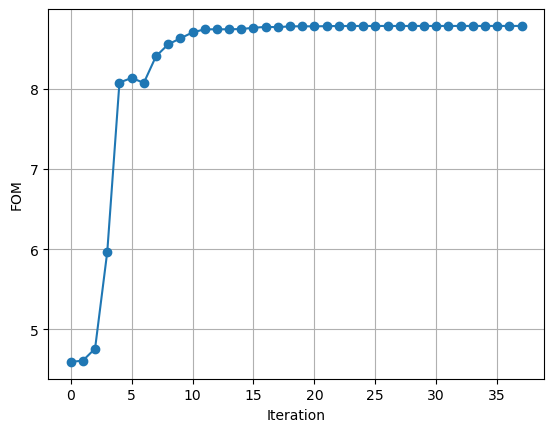

In [10]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

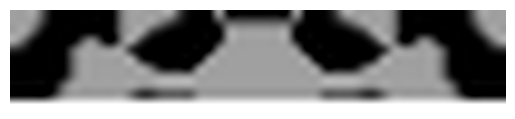

In [11]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

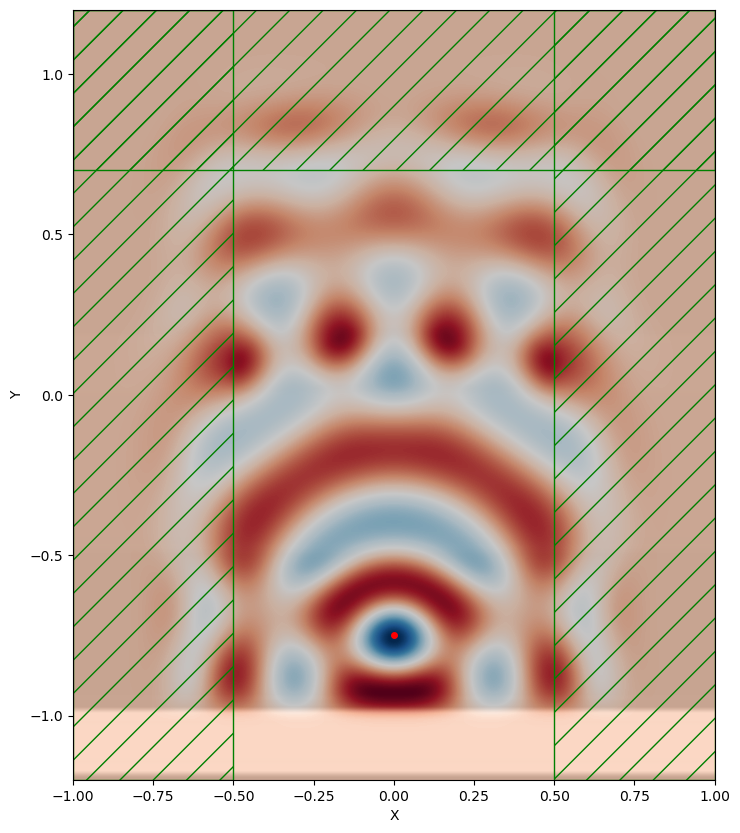

In [12]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [13]:
opt.sim.reset_meep()

In [14]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [15]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

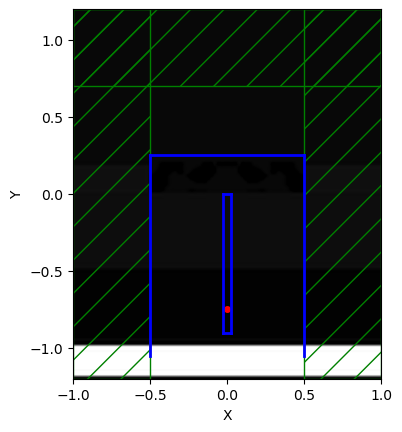

In [16]:
opt.sim.plot2D()

In [17]:
opt.sim.run(until=100.0)

In [18]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [19]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [20]:
print(flux_waveguide)

[4.50367201e-06 2.36031176e-05 1.10085775e-04 4.55713347e-04
 1.70128925e-03 5.71754122e-03 1.62130410e-02 3.96708280e-02
 8.24731169e-02 1.41732242e-01 2.22437326e-01 3.26505514e-01
 4.43443928e-01 4.33990837e-01 3.45611679e-01 2.66965306e-01
 1.84898953e-01 1.05254838e-01 5.22917412e-02 2.24112155e-02
 8.16219638e-03 2.58296353e-03 7.26087573e-04 1.78913565e-04
 3.89517968e-05]


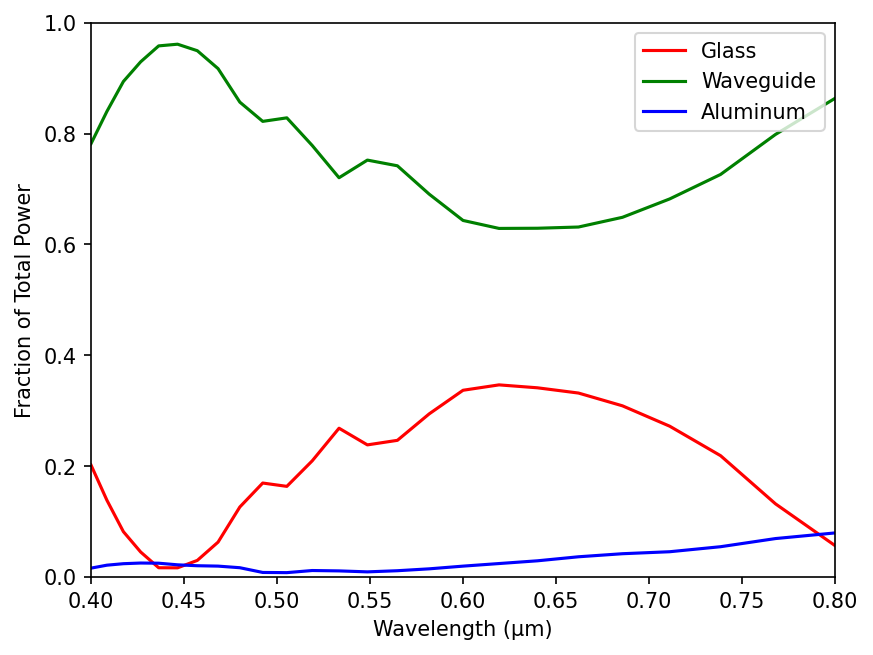

In [21]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [22]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [23]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)

In [24]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

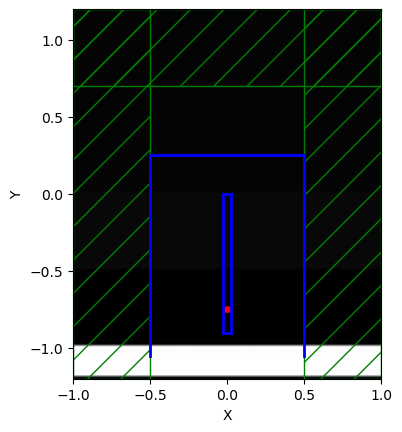

In [25]:
opt.simo.plot2D()

In [26]:
opt.simo.run(until=300.0)

In [27]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [28]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

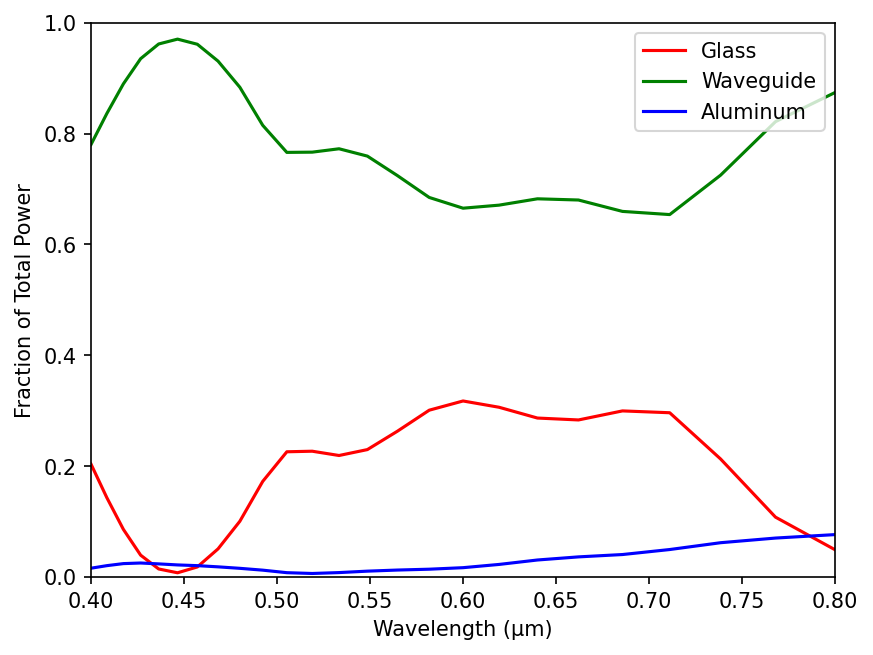

In [29]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [34]:
opt.simo.reset_meep()

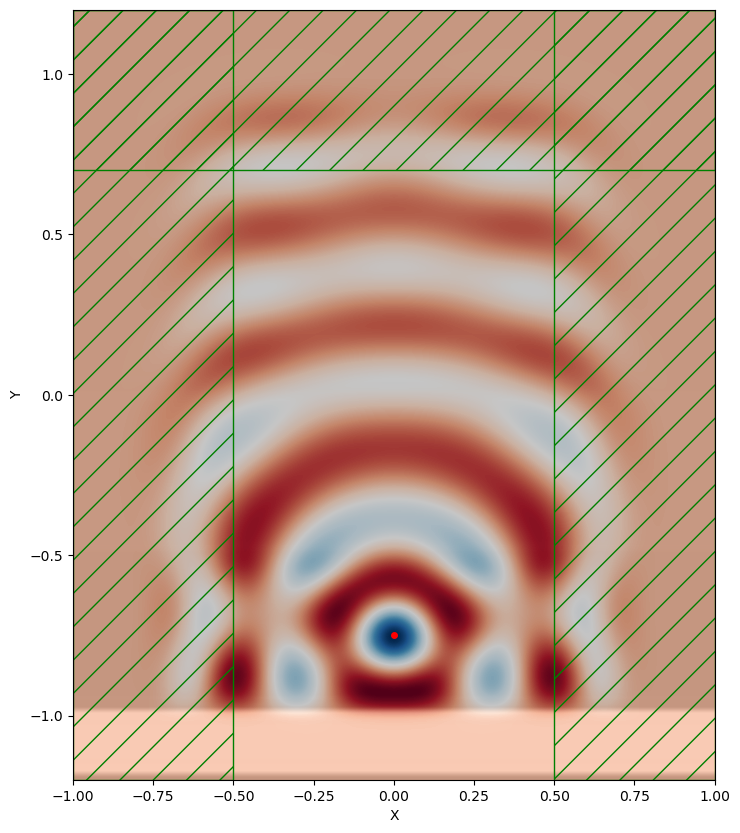

In [35]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()